*Script criado por Rafael Cesario de Abreu em Fev/2022 para o curso Aplicações em meteorologia usando Python*

*Revisado por Rita Yuri Ynoue e Natália Machado Crespo*

# Aula 5

Nessa aula iremos ver:

*   Como fazer a análise de componentes principais utilizando o pacote `statsmodels`
*   Alternar entre o `pandas` e o `xarray` conforme for mais prático
*   Fazer figuras para analisar os resultados

Instalando pacotes que serão usados:

In [1]:
!pip uninstall -y shapely
!pip install -q netcdf4
!pip install shapely cartopy --no-binary shapely --no-binary cartopy

Found existing installation: Shapely 1.8.0
Uninstalling Shapely-1.8.0:
  Successfully uninstalled Shapely-1.8.0
     |████████████████████████████████| 278 kB 6.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 10.8 MB 49.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 42.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 44.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 45.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 2.8 MB/s 
  Created wheel for 

Importando os pacotes que serão utilizados

In [2]:
import pandas as pd
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Dica**: Existe uma padronização de estilo de código para o Python chamado [PEP8](https://www.python.org/dev/peps/pep-0008/) que deve ser usado sempre que possível, facilitando a comparação de códigos de diferentes autores.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Vamos aplicar a PCA nos dados de temperatura da superfície do mar para detectar os principais padrões

In [4]:
ds = xr.open_dataset('drive/Shareddrives/Curso_Python2022/dados_NCEP_NOAA/sst.mnmean.nc')

ds

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nbnds: 2, time: 449)
Coordinates:
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2019-04-01
Dimensions without coordinates: nbnds
Data variables:
    sst        (time, lat, lon) float32 ...
    time_bnds  (time, nbnds) datetime64[ns] ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Wed Apr  6 13:47:45 2005: ncks -d time,0,278 SAVEs/sst.mn...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

O resultado da PCA irá depender bastante da área que é definida. Dessa forma,  vamos selecionar apenas a área do Pacífico equatorial para ver se encontramos padrões relacionados ao El Niño. Para fazer isso, usamos o comando `sel` que irá fazer uma seleção nas latitudes. Por fim, fazemos um plot simples apenas para verificar se as coordenadas estão corretas. O comando `isel` funciona de forma análoga ao comando `iloc` do pandas: seleciona o dado com base no índice da matriz. Nesse caso, estamos plotando o primeiro tempo da `sst` na figura.

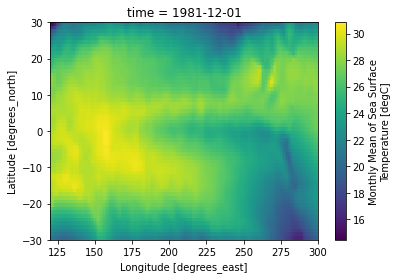

In [5]:
ds = ds.sel(lat=slice(30, -30), lon=slice(120, 300))
ds['sst'].isel(time=0).plot()

O arquivo de SST do "NOAA Optimum Interpolation (OI) Sea Surface Temperature (SST) V2" faz uma interpolação simples nos pontos de continente, dessa forma é melhor primeiramente removermos esses pontos. Um jeito de fazer isso é utilizando um shapefile do oceano como foi mostrado na Aula 3. No entanto, podemos fazer de um outro jeito, utilizando um netcdf que possui as mesmas coordenadas desse nosso arquivo de SST

In [6]:
mask = xr.open_dataset('drive/Shareddrives/Curso_Python2022/dados_NCEP_NOAA/lsmask.nc')

mask

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-10-29
Data variables:
    mask     (time, lat, lon) float32 ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Created 10/2002 by RHS
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

Repare que o oceano possui um valor de 1 e o continente possui valores de 0, dessa forma, só precisamos pegar todos os pontos onde a mascara é igual a 1 para filtrar apenas os pontos de oceano

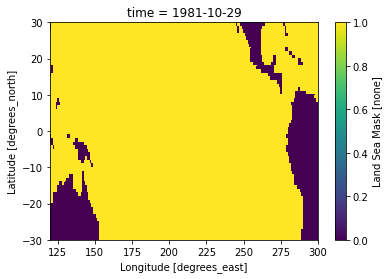

In [7]:
mask = mask.sel(lat=slice(30, -30), lon=slice(120, 300)) # seleciona area
mask['mask'].isel(time=0).plot()

Para fazer isso usamos o comando `where` do `xarray`, que funciona de forma similar ao que já fizemos com o `pandas`. Como o arquivo de máscara tem um timestep precisamos selecionar o primeiro tempo para que ele use a matriz 2D para filtrar esses dados de forma correta:

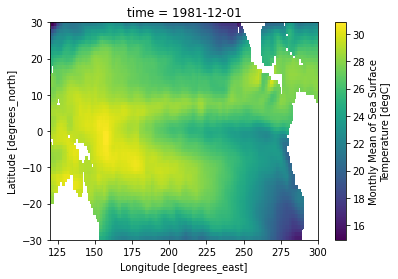

In [8]:
ds_ocean = ds.where(mask['mask'].isel(time=0) == 1)  # filtra valores apenas para o oceano

ds_ocean['sst'].isel(time=0).plot()

Para construir a matriz $X$ precisamos garantir que as colunas dessa matriz sejam os pontos de grade enquanto que as linhas sejam os tempos. Dessa forma, convertemos a matriz de dados do `xarray` para um dataframe do `pandas`. Após isso, criamos uma coluna `coord` que possui um identificador único para o ponto de grade de cada célula. 

In [9]:
df = ds_ocean['sst'].to_dataframe()  # converte em dataframe
df = df.reset_index() # redefine o indice
df['coord'] = df['lon'].astype(str) + '_' + df['lat'].astype(str) # cria coluna de ponto (lon_lat)

df

,time,lat,lon,sst,coord
0,1981-12-01,29.5,120.5,NaN,120.5_29.5
1,1981-12-01,29.5,121.5,14.920000,121.5_29.5
2,1981-12-01,29.5,122.5,15.280000,122.5_29.5
3,1981-12-01,29.5,123.5,16.109999,123.5_29.5
4,1981-12-01,29.5,124.5,17.529999,124.5_29.5
...,...,...,...,...,...
4849195,2019-04-01,-29.5,295.5,NaN,295.5_-29.5
4849196,2019-04-01,-29.5,296.5,NaN,296.5_-29.5
4849197,2019-04-01,-29.5,297.5,NaN,297.5_-29.5
4849198,2019-04-01,-29.5,298.5,NaN,298.5_-29.5


Repare que existem vários NaNs no dataframe. Isso ocorre por conta dos pontos que filtramos no continente. A PCA não aceita valores faltantes, dessa forma precisamos remover esses valores.

In [10]:
df = df.dropna()

df

,time,lat,lon,sst,coord
1,1981-12-01,29.5,121.5,14.920000,121.5_29.5
2,1981-12-01,29.5,122.5,15.280000,122.5_29.5
3,1981-12-01,29.5,123.5,16.109999,123.5_29.5
4,1981-12-01,29.5,124.5,17.529999,124.5_29.5
5,1981-12-01,29.5,125.5,18.590000,125.5_29.5
...,...,...,...,...,...
4849184,2019-04-01,-29.5,284.5,17.699999,284.5_-29.5
4849185,2019-04-01,-29.5,285.5,17.459999,285.5_-29.5
4849186,2019-04-01,-29.5,286.5,17.150000,286.5_-29.5
4849187,2019-04-01,-29.5,287.5,16.809999,287.5_-29.5


Usando o comando `pivot_table` conseguimos refatorar o DataFrame para que as colunas sejam os identificadores únicos em `coord`, uma vez que cada ponto é repetido `n` vezes, onde `n` é o número de tempos no arquivo, e que a coluna `time` seja usada como índice.

In [11]:
df = df.pivot_table(index='time', columns='coord', values='sst')

df

coord,120.5_-0.5,120.5_-10.5,120.5_-11.5,120.5_-12.5,120.5_-13.5,120.5_-14.5,120.5_-15.5,120.5_-16.5,120.5_-17.5,120.5_-18.5,120.5_-19.5,120.5_-3.5,120.5_-4.5,120.5_-5.5,120.5_-6.5,120.5_-7.5,120.5_-8.5,120.5_-9.5,120.5_0.5,120.5_1.5,120.5_10.5,120.5_11.5,120.5_12.5,120.5_13.5,120.5_14.5,120.5_16.5,120.5_17.5,120.5_18.5,120.5_19.5,120.5_2.5,120.5_20.5,120.5_21.5,120.5_22.5,120.5_23.5,120.5_24.5,120.5_25.5,120.5_26.5,120.5_27.5,120.5_3.5,120.5_4.5,...,298.5_13.5,298.5_14.5,298.5_15.5,298.5_16.5,298.5_17.5,298.5_18.5,298.5_19.5,298.5_20.5,298.5_21.5,298.5_22.5,298.5_23.5,298.5_24.5,298.5_25.5,298.5_26.5,298.5_27.5,298.5_28.5,298.5_29.5,298.5_9.5,299.5_10.5,299.5_11.5,299.5_12.5,299.5_13.5,299.5_14.5,299.5_15.5,299.5_16.5,299.5_17.5,299.5_18.5,299.5_19.5,299.5_20.5,299.5_21.5,299.5_22.5,299.5_23.5,299.5_24.5,299.5_25.5,299.5_26.5,299.5_27.5,299.5_28.5,299.5_29.5,299.5_8.5,299.5_9.5
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1981-12-01,28.840000,28.849998,29.070000,29.459999,29.369999,29.129999,28.900000,28.789999,28.519999,28.209999,28.000000,29.109999,28.719999,28.490000,28.340000,28.289999,28.469999,28.650000,28.709999,28.559999,27.740000,27.680000,27.959999,27.980000,27.889999,26.029999,25.609999,25.240000,24.920000,28.490000,24.469999,23.990000,23.389999,22.490000,21.109999,20.100000,19.309999,19.070000,28.510000,28.660000,...,28.080000,28.039999,27.949999,27.900000,27.760000,27.510000,27.180000,26.830000,26.539999,26.230000,25.820000,25.279999,24.650000,24.049999,23.490000,22.879999,22.279999,27.629999,27.849998,27.980000,28.080000,28.070000,27.980000,27.859999,27.789999,27.650000,27.430000,27.119999,26.799999,26.519999,26.240000,25.849998,25.350000,24.760000,24.180000,23.600000,22.920000,22.269999,27.670000,27.719999
1982-01-01,28.580000,28.879999,29.170000,29.420000,29.539999,29.539999,29.559999,29.769999,29.719999,29.599998,29.500000,28.670000,28.400000,28.170000,28.019999,28.059999,28.340000,28.609999,28.420000,28.279999,27.049999,27.019999,27.080000,27.199999,27.180000,25.080000,24.750000,24.580000,24.469999,28.199999,24.359999,24.010000,23.279999,21.949999,19.660000,18.020000,17.020000,17.029999,28.180000,28.099998,...,27.119999,27.049999,26.889999,26.660000,26.449999,26.240000,26.029999,25.830000,25.639999,25.359999,24.930000,24.320000,23.789999,23.289999,22.719999,21.930000,21.119999,26.719999,26.879999,26.990000,27.109999,27.109999,26.990000,26.799999,26.549999,26.340000,26.139999,25.939999,25.760000,25.559999,25.289999,24.900000,24.369999,23.879999,23.389999,22.789999,21.959999,21.129999,26.869999,26.830000
1982-02-01,28.650000,28.969999,29.070000,29.119999,29.039999,28.920000,28.910000,29.189999,29.320000,29.389999,29.429998,28.689999,28.439999,28.269999,28.189999,28.289999,28.529999,28.779999,28.459999,28.309999,26.099998,26.049999,26.080000,26.330000,26.539999,25.139999,24.850000,24.619999,24.439999,28.199999,24.330000,24.100000,23.420000,22.000000,19.639999,17.650000,16.330000,16.160000,28.049999,27.660000,...,26.859999,26.719999,26.480000,26.250000,26.049999,25.869999,25.689999,25.449999,25.230000,24.930000,24.500000,23.949999,23.529999,23.160000,22.689999,21.949999,21.029999,26.799999,26.849998,26.849998,26.879999,26.830000,26.650000,26.400000,26.180000,25.969999,25.789999,25.609999,25.379999,25.160000,24.879999,24.490000,24.049999,23.670000,23.289999,22.769999,22.020000,21.109999,26.939999,26.889999
1982-03-01,29.029999,29.080000,29.219999,29.420000,29.449999,29.439999,29.490000,29.619999,29.699999,29.719999,29.699999,28.900000,28.580000,28.449999,28.420000,28.490000,28.709999,28.900000,28.849998,28.750000,27.269999,27.219999,27.240000,27.400000,27.580000,26.809999,26.580000,26.289999,25.949999,28.670000,25.559999,25.039999,24.129999,22.629999,20.600000,18.719999,17.379999,17.029999,28.559999,28.449999,...,26.639999,26.519999,26.309999,26.049999,25.799999,25.590000,25.430000,25.250000,25.080000,24.859999,24.570000,24.250000,23.969999,23.629999,23.080000,22.309999,21

Existem inúmeros pacotes que fazem a análise de componentes principais como o `statsmodels`, `sklearn` e `eofs`. Vamos usar nesse curso o módulo PCA do `statsmodels`, uma vez que me parece um pouco mais intuitivo e genérico o suficiente para ser usado para outras aplicações. Alguns dos atributos que são acessíveis do objeto criado são: 

* **scores** array ou DataFrame: 
array (nobs x ncomp) das componentes principais

* **loadings** array ou DataFrame: 
array (ncomp x nvar) dos loadings da componente principal usado para criar os scores

* **eigenvals** array ou Series: 
array (nvar) dos autovalores

* **eigenvecs** array ou DataFrame: 
array (nvar x nvar) dos autovetores

In [12]:
pca = sm.multivariate.PCA(df, standardize=False, demean=False, normalize=False)  # aplica a PCA

Vamos calcular a variância total explicada e plotar, que é dada por $var_i = \lambda_i / \sum_{j=1}^p \lambda_j$

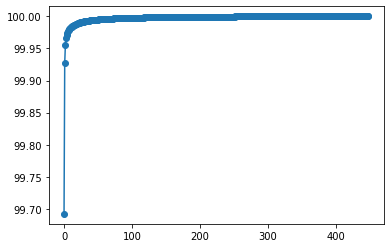

In [13]:
explained_variance = 100 * pca.eigenvals / pca.eigenvals.sum()  # variância explicada
explained_variance_cumsum = explained_variance.cumsum()  # soma acumulada

fig, ax = plt.subplots()

explained_variance_cumsum.plot(ax=ax, marker='o')

Vemos que mais de 99 % da variância é explicada apenas pela primeira PC. Vamos observar agora os loadings. Veja que o formato do dataframe conserva os nossos identificadores únicos da coordenada de cada ponto de grade. Dessa forma, podemos fazer ~~de forma simples~~ a conversão do dataframe para um dataset do `xarray`, que fica mais simples de manipular para fazer os plots.

In [ ]:
pca.loadings

,comp_000,comp_001,comp_002,comp_003,comp_004,comp_005,comp_006,comp_007,comp_008,comp_009,comp_010,comp_011,comp_012,comp_013,comp_014,comp_015,comp_016,comp_017,comp_018,comp_019,comp_020,comp_021,comp_022,comp_023,comp_024,comp_025,comp_026,comp_027,comp_028,comp_029,comp_030,comp_031,comp_032,comp_033,comp_034,comp_035,comp_036,comp_037,comp_038,comp_039,...,comp_409,comp_410,comp_411,comp_412,comp_413,comp_414,comp_415,comp_416,comp_417,comp_418,comp_419,comp_420,comp_421,comp_422,comp_423,comp_424,comp_425,comp_426,comp_427,comp_428,comp_429,comp_430,comp_431,comp_432,comp_433,comp_434,comp_435,comp_436,comp_437,comp_438,comp_439,comp_440,comp_441,comp_442,comp_443,comp_444,comp_445,comp_446,comp_447,comp_448
coord,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
120.5_-0.5,-0.011427,0.000720,0.004162,0.003587,0.009901,-0.001855,-0.003625,-0.001224,0.001228,0.005191,0.001351,0.000667,0.006167,-0.001589,0.003317,-0.010126,-0.003352,0.000272,0.011670,0.016342,0.006647,-0.004858,0.003551,0.008582,0.012805,0.003159,-0.008789,0.001291,-0.002856,0.004883,-0.001481,-0.005709,0.002526,0.011380,0.000098,-0.001880,-0.023594,0.018589,-0.003732,-0.009576,...,0.001024,-0.016169,0.006374,-0.030268,0.003845,-0.000544,-0.012111,-0.002633,-0.009842,0.011298,0.025824,-0.024605,-0.018436,0.011100,-0.002096,0.022149,0.003662,-0.001971,-0.018694,0.018221,-0.000694,-0.018728,0.010733,0.011126,-0.005928,0.031779,0.018173,-0.012224,-0.003977,-0.021678,0.006642,0.011686,-0.010583,-0.006095,0.012349,-0.019022,0.026316,0.017565,-0.007453,-0.011676
120.5_-10.5,-0.011065,-0.008260,0.014103,-0.009805,0.016486,-0.017833,-0.013272,0.004995,0.000096,0.003555,-0.006445,0.007752,0.012874,0.009241,-0.009988,-0.008760,-0.005675,-0.004711,-0.001257,-0.001664,0.008343,-0.003092,0.013558,-0.010748,0.017224,-0.004268,0.001466,0.014272,0.006797,-0.002999,-0.009516,-0.014215,0.018499,-0.019169,-0.003573,-0.002122,0.008296,0.016072,-0.022468,0.014786,...,0.008961,-0.002192,0.017465,0.006770,-0.016358,-0.020824,-0.013700,0.002630,0.005901,0.012813,-0.019619,-0.003913,0.000129,0.005617,-0.004563,-0.007188,-0.002709,-0.010564,0.010831,-0.002737,-0.008073,-0.002733,-0.002376,0.007493,0.011420,-0.010309,0.011807,0.012981,-0.017334,0.011339,0.000413,-0.008698,-0.007011,-0.002430,-0.010548,0.008401,0.006200,0.010595,0.003883,0.008290
120.5_-11.5,-0.011116,-0.008422,0.014232,-0.010798,0.017349,-0.018792,-0.012950,0.003581,0.000079,0.003531,-0.007081,0.006555,0.013922,0.006096,-0.009264,-0.008063,-0.006136,-0.006353,-0.001810,-0.001432,0.010635,0.001197,0.011306,-0.015137,0.017481,-0.002269,0.001453,0.012043,0.007560,-0.004977,-0.006917,-0.012807,0.022912,-0.023625,-0.002402,-0.004910,0.008922,0.013711,-0.025848,0.017843,...,0.000158,0.006153,0.011280,0.006506,-0.006402,-0.024820,-0.015585,-0.006068,0.006380,0.008318,-0.012736,-0.001115,0.002411,0.009140,-0.004613,-0.011355,-0.005199,-0.013133,0.011343,0.006294,-0.006736,0.001143,-0.004053,0.009119,0.019065,-0.017977,0.010672,0.003328,-0.026682,0.010036,-0.003114,0.000927,-0.006605,-0.001832,-0.008636,0.001894,0.011088,0.006204,0.007021,0.012719
120.5_-12.5,-0.011177,-0.008290,0.013408,-0.010080,0.018577,-0.018589,-0.012040,0.001258,-0.000856,0.002558,-0.007276,0.006349,0.014026,0.004867,-0.005969,-0.007219,-0.005232,-0.008321,-0.001926,-0.002677,0.011130,0.007921,0.009416,-0.018270,0.015797,0.000175,-0.000342,0.011985,0.009188,-0.007951,-0.002797,-0.011135,0.025990,-0.028374,-0.003993,-0.008069,0.008715,0.012467,-0.029868,0.020199,...,-0.006826,0.011590,-0.000824,0.000258,0.008436,-0.018455,-0.002996,-0.011421,-0.000730,-0.006739,-0.011915,-0.003252,0.005714,0.000558,-0.014547,-0.002477,-0.011748,-0.005901,0.003815,-0.003597,-0.014695,-0.004769,0.003575,0.022994,0.021378,-0.014083,-0.002539,-0.012942,-0.018468,0.012606,-0.015807,-0.000553,-0.007121,-0.000741,-0.009684,-0.011378,0.014082,0.000733,0.001838,0.000458
120.5_-13.5,-0.011190,-0.008343,0.012029,-0.008004,0.019954,-0.018023,-0.01252

Para convertermos para um objeto do `xarray` precisamos reconstruir as colunas de latitude e longitude a partir da coluna de coordenada (`coord`). Para isso usamos o comando `apply` como já fizemos anteriormente:

In [14]:
loadings = pca.loadings.reset_index()

loadings['lon'] = loadings['coord'].apply(lambda x: float(x.split('_')[0])) # define uma coluna de longitude a partir do indice com o ponto de grade
loadings['lat'] = loadings['coord'].apply(lambda x: float(x.split('_')[1])) # define uma coluna de latitude a partir do indice com o ponto de grade

loadings = loadings.set_index(['lat', 'lon']) # define como indice a latitude e longitude
loadings = loadings.drop(['coord'], axis=1) # removemos a coluna de coordenadas pois não é mais necessária

loadings

,,comp_000,comp_001,comp_002,comp_003,comp_004,comp_005,comp_006,comp_007,comp_008,comp_009,comp_010,comp_011,comp_012,comp_013,comp_014,comp_015,comp_016,comp_017,comp_018,comp_019,comp_020,comp_021,comp_022,comp_023,comp_024,comp_025,comp_026,comp_027,comp_028,comp_029,comp_030,comp_031,comp_032,comp_033,comp_034,comp_035,comp_036,comp_037,comp_038,comp_039,...,comp_409,comp_410,comp_411,comp_412,comp_413,comp_414,comp_415,comp_416,comp_417,comp_418,comp_419,comp_420,comp_421,comp_422,comp_423,comp_424,comp_425,comp_426,comp_427,comp_428,comp_429,comp_430,comp_431,comp_432,comp_433,comp_434,comp_435,comp_436,comp_437,comp_438,comp_439,comp_440,comp_441,comp_442,comp_443,comp_444,comp_445,comp_446,comp_447,comp_448
lat,lon,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-0.5,120.5,-0.011427,0.000720,0.004162,0.003587,0.009901,-0.001855,-0.003625,-0.001224,0.001228,0.005191,0.001351,0.000667,0.006167,-0.001589,0.003317,-0.010126,-0.003352,0.000272,0.011670,0.016342,0.006647,-0.004858,0.003551,0.008582,0.012805,0.003159,-0.008789,0.001291,-0.002856,0.004883,-0.001481,-0.005709,0.002526,0.011380,0.000098,-0.001880,-0.023594,0.018589,-0.003732,-0.009576,...,0.001024,-0.016169,0.006374,-0.030268,0.003845,-0.000544,-0.012111,-0.002633,-0.009842,0.011298,0.025824,-0.024605,-0.018436,0.011100,-0.002096,0.022149,0.003662,-0.001971,-0.018694,0.018221,-0.000694,-0.018728,0.010733,0.011126,-0.005928,0.031779,0.018173,-0.012224,-0.003977,-0.021678,0.006642,0.011686,-0.010583,-0.006095,0.012349,-0.019022,0.026316,0.017565,-0.007453,-0.011676
-10.5,120.5,-0.011065,-0.008260,0.014103,-0.009805,0.016486,-0.017833,-0.013272,0.004995,0.000096,0.003555,-0.006445,0.007752,0.012874,0.009241,-0.009988,-0.008760,-0.005675,-0.004711,-0.001257,-0.001664,0.008343,-0.003092,0.013558,-0.010748,0.017224,-0.004268,0.001466,0.014272,0.006797,-0.002999,-0.009516,-0.014215,0.018499,-0.019169,-0.003573,-0.002122,0.008296,0.016072,-0.022468,0.014786,...,0.008961,-0.002192,0.017465,0.006770,-0.016358,-0.020824,-0.013700,0.002630,0.005901,0.012813,-0.019619,-0.003913,0.000129,0.005617,-0.004563,-0.007188,-0.002709,-0.010564,0.010831,-0.002737,-0.008073,-0.002733,-0.002376,0.007493,0.011420,-0.010309,0.011807,0.012981,-0.017334,0.011339,0.000413,-0.008698,-0.007011,-0.002430,-0.010548,0.008401,0.006200,0.010595,0.003883,0.008290
-11.5,120.5,-0.011116,-0.008422,0.014232,-0.010798,0.017349,-0.018792,-0.012950,0.003581,0.000079,0.003531,-0.007081,0.006555,0.013922,0.006096,-0.009264,-0.008063,-0.006136,-0.006353,-0.001810,-0.001432,0.010635,0.001197,0.011306,-0.015137,0.017481,-0.002269,0.001453,0.012043,0.007560,-0.004977,-0.006917,-0.012807,0.022912,-0.023625,-0.002402,-0.004910,0.008922,0.013711,-0.025848,0.017843,...,0.000158,0.006153,0.011280,0.006506,-0.006402,-0.024820,-0.015585,-0.006068,0.006380,0.008318,-0.012736,-0.001115,0.002411,0.009140,-0.004613,-0.011355,-0.005199,-0.013133,0.011343,0.006294,-0.006736,0.001143,-0.004053,0.009119,0.019065,-0.017977,0.010672,0.003328,-0.026682,0.010036,-0.003114,0.000927,-0.006605,-0.001832,-0.008636,0.001894,0.011088,0.006204,0.007021,0.012719
-12.5,120.5,-0.011177,-0.008290,0.013408,-0.010080,0.018577,-0.018589,-0.012040,0.001258,-0.000856,0.002558,-0.007276,0.006349,0.014026,0.004867,-0.005969,-0.007219,-0.005232,-0.008321,-0.001926,-0.002677,0.011130,0.007921,0.009416,-0.018270,0.015797,0.000175,-0.000342,0.011985,0.009188,-0.007951,-0.002797,-0.011135,0.025990,-0.028374,-0.003993,-0.008069,0.008715,0.012467,-0.029868,0.020199,...,-0.006826,0.011590,-0.000824,0.000258,0.008436,-0.018455,-0.002996,-0.011421,-0.000730,-0.006739,-0.011915,-0.003252,0.005714,0.000558,-0.014547,-0.002477,-0.011748,-0.005901,0.003815,-0.003597,-0.014695,-0.004769,0.003575,0.022994,0.021378,-0.014083,-0.002539,-0.012942,-0.018468,0.012606,-0.015807,-0.000553,-0.007121,-0.000741,-0.009684,-0.011378,0.014082,0.000733,0.001838,0.000458
-13.5,120.5,-0.011190,-0.008343,0.012029,-0.008004,0.019954,-0.018023,-0.01

Usamos o comando `to_xarray` para converter o dataframe para um dataset. Veja que as colunas são agora variáveis do dataset que são definidos em um array 2D (lat, lon) que se tornam as coordenadas:

In [15]:
loadings = loadings.to_xarray()

loadings  # lat e lon que eram os índices no dataframe se tornam as coordenadas no xarray

<xarray.Dataset>
Dimensions:   (lat: 60, lon: 180)
Coordinates:
  * lat       (lat) float64 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 296.5 297.5 298.5 299.5
Data variables: (12/449)
    comp_000  (lat, lon) float64 nan nan nan ... -0.009553 -0.009555 -0.009556
    comp_001  (lat, lon) float64 nan nan nan nan ... 0.02045 0.02037 0.02027
    comp_002  (lat, lon) float64 nan nan nan ... 0.0001274 0.0003682 0.0006916
    comp_003  (lat, lon) float64 nan nan nan nan ... 0.003691 0.003444 0.003224
    comp_004  (lat, lon) float64 nan nan nan nan ... -0.02299 -0.0227 -0.02263
    comp_005  (lat, lon) float64 nan nan nan nan ... 0.002998 0.002887 0.002716
    ...        ...
    comp_443  (lat, lon) float64 nan nan nan ... 0.006369 -0.0003381 -0.01086
    comp_444  (lat, lon) float64 nan nan nan ... 0.0001445 -0.003881 -0.01424
    comp_445  (lat, lon) float64 nan nan nan nan ... 0.006404 0.02418 0.03863
    comp_446  (lat, lon) float64 nan nan nan nan ... 0.00233 0.007223 0.01742
    comp_447  (lat, lon) float64 nan nan nan nan ... 0.002937 -0.002119 -0.00969
    comp_448  (lat, lon) float64 nan nan nan ... 0.001839 -0.001505 -0.009797

Vamos fazer um plot simples agora só para ver como está. Veja que ao tornar o dataframe do `pandas` para um objeto no `xarray` ele já inclui os NaNs onde é continente, uma vez que essas latitudes e longitudes não têm nenhum valor definidos. Isso torna mais simples a reconstrução do sinal quando usamos as máscaras

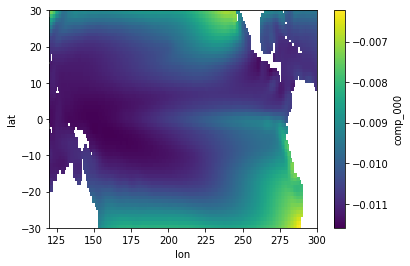

In [16]:
loadings['comp_000'].plot()

Vamos plotar agora esse primeiro loading em um mapa, junto com os scores. Como um [plot do pacífico cruza a linha de data](https://stackoverflow.com/questions/13856123/setting-up-a-map-which-crosses-the-dateline-in-cartopy) é um pouco complicado fazer essa figura com a projeção `PlateCarree`, para isso primeiro precisamos definir uma longitude central para o mapa mas manter os dados na projeção original para que eles continuem na forma correta. 

Text(0.5, 1.0, 'Score')

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarnin

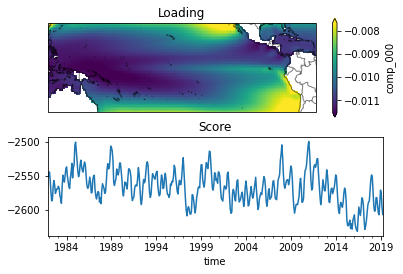

In [17]:
fig = plt.figure(figsize=(6,4))

ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(212)

loadings['comp_000'].plot(ax=ax1, robust=True, transform=ccrs.PlateCarree())
ax1.coastlines('50m', edgecolor='k', alpha=0.5)
ax1.add_feature(cfeature.BORDERS, edgecolor='k', alpha=0.5)
ax1.set_title('Loading')

ax1.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())

pca.scores['comp_000'].plot(ax=ax2)
ax2.set_title('Score')

Repare que todos os valores do loading possuem o mesmo sinal, com algumas áreas com valores menores do que em outras. Observando os scores vemos dois padrões bem definidos, um ciclo sazonal de mínimos e máximos e uma tendência de diminuição dos valores dos scores, ou seja, eles estão cada vez mais negativos.

Lembre-se que:
$\text{PC}_1 = Xq_1 = \begin{bmatrix} x_{11} q_{11} + x_{12} q_{12} + \cdots + x_{1p} q_{1p} \\ \vdots \\ x_{n1} q_{11} + x_{n2} q_{12} + \cdots +  x_{np} q_{1p}  \end{bmatrix}$   

E portanto que a matriz de PCs é dada por:
$\text{PC} = XQ$

Como $QQ^T = I$ temos que também que $\text{X} = \text{PC} Q^T$. Dessa forma, temos que interpretar uma contribuição positiva ou negativa para a temperatura com base na multiplicação do valor da PC com relação ao valor do loading. Ou seja, onde $q_i < 0$ e $PC_i < 0$ então há uma contribuição positiva para a temperatura do mar, por exemplo.


Um dos jeitos de observamos outros padrões dominantes é removendo essa componente média, relacionada à sazonalidade e à tendência. Para isso podemos utilizar as funções definidas na Aula 3. No entanto, vamos mostrar como fazer isso usando o `pandas`, uma vez que trasnformamos o objeto do `xarray` em um objeto do `pandas`.

Criamos então uma função que calcula a anomalia, assim como mostramos nas aulas sobre o `pandas`. Depois disso usamos a função `detrend` do `statsmodel` que remove a tendência linear de cada uma das colunas (poderíamos também utilizar o `detrend` do `scipy` conforme mostrado na aula de dados multivariados).

In [18]:
def calculate_anomaly(x, idate='1981-01-01', edate='2010-12-31'):
    return x - x.loc[idate:edate].mean()

df_anomaly = df.groupby(df.index.month).apply(calculate_anomaly)  # remove sazonalidade
df_detrend = sm.tsa.tsatools.detrend(df_anomaly)  # remove tendência

Vamos ver a mudança em cada um dos passos na média espacial:

Text(0.5, 1.0, 'Anomalia sem tendência')

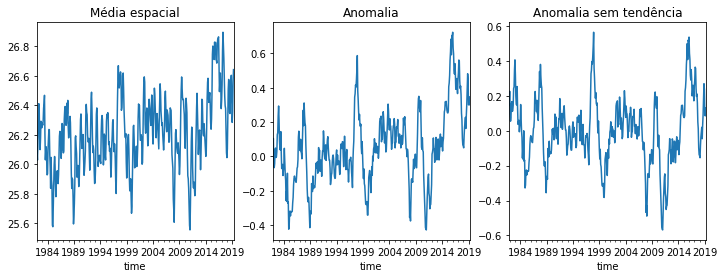

In [19]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4))

df.mean(axis=1).plot(ax=ax1)
df_anomaly.mean(axis=1).plot(ax=ax2)
df_detrend.mean(axis=1).plot(ax=ax3)

ax1.set_title('Média espacial')
ax2.set_title('Anomalia')
ax3.set_title('Anomalia sem tendência')

Vamos repetir novamente o processo e aplicar a PCA nos dados com a sazonalidade e a tendência removidos. Veja que agora a primeira componente responde por menos de 40 % da variância total dos dados.

In [20]:
pca = sm.multivariate.PCA(df_detrend, standardize=False, demean=False, normalize=False)

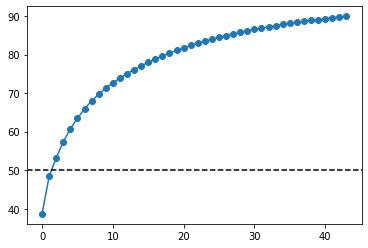

In [21]:
explained_variance = 100 * pca.eigenvals / pca.eigenvals.sum()
explained_variance_cumsum = explained_variance.cumsum()

fig, ax = plt.subplots()

explained_variance_cumsum[explained_variance_cumsum <= 90].plot(ax=ax, marker='o') # Plota apenas as componentes que junto somam 90 %
ax.axhline(50, color='k', ls='--') # da destaque para 50 %

Em vez de repetirmos todo o processo da transformação dos loadings em um dataset, vamos criar uma função para facilitar o uso futuro.

In [22]:
def format_loadings(loadings):
    loadings = loadings.reset_index()

    # cria coluna com os valores de lat e lon
    loadings['lon'] = loadings['coord'].apply(lambda x: float(x.split('_')[0])) 
    loadings['lat'] = loadings['coord'].apply(lambda x: float(x.split('_')[1]))

    # define lat e lon como índices do dataframe e converte em um dataset
    loadings = loadings.set_index(['lat', 'lon'])
    loadings = loadings.drop(['coord'], axis=1)
    loadings = loadings.to_xarray()

    return loadings

In [23]:
loadings = format_loadings(pca.loadings)

loadings

<xarray.Dataset>
Dimensions:   (lat: 60, lon: 180)
Coordinates:
  * lat       (lat) float64 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 296.5 297.5 298.5 299.5
Data variables: (12/449)
    comp_000  (lat, lon) float64 nan nan nan ... 0.0009035 0.0008728 0.0007708
    comp_001  (lat, lon) float64 nan nan nan nan ... 0.004193 0.004256 0.004268
    comp_002  (lat, lon) float64 nan nan nan nan ... -0.009702 -0.009566 -0.0096
    comp_003  (lat, lon) float64 nan nan nan ... -0.002158 -0.00122 -0.0002483
    comp_004  (lat, lon) float64 nan nan nan ... -0.0002715 -0.0004438
    comp_005  (lat, lon) float64 nan nan nan nan ... -0.01148 -0.0112 -0.0107
    ...        ...
    comp_443  (lat, lon) float64 nan nan nan nan ... 0.007221 -0.01036 0.005539
    comp_444  (lat, lon) float64 nan nan nan nan ... 0.01394 -0.001794 0.01554
    comp_445  (lat, lon) float64 nan nan nan nan ... -0.004432 -0.007254 0.01674
    comp_446  (lat, lon) float64 nan nan nan ... -0.007653 -0.001427 -0.01301
    comp_447  (lat, lon) float64 nan nan nan nan ... 0.00273 0.004968 0.01212
    comp_448  (lat, lon) float64 nan nan nan nan ... -0.01476 0.006494 0.03318

Como agora as componentes respondem individualmente por uma menor parte da variância, vamos plotar as primeiras seis. Primeiramente os loadings e posteriormente os scores. Veja que a primeira componente possui um padrão de aquecimento no Oceano Pacífico central que lembra muito a ocorrência do El Niño. Olhando os scores essa associação ganha mais evidências como por exemplo, o máximo da série ocorrendo em 1997/1998, ano do El Niño mais intenso já registrado.

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarnin

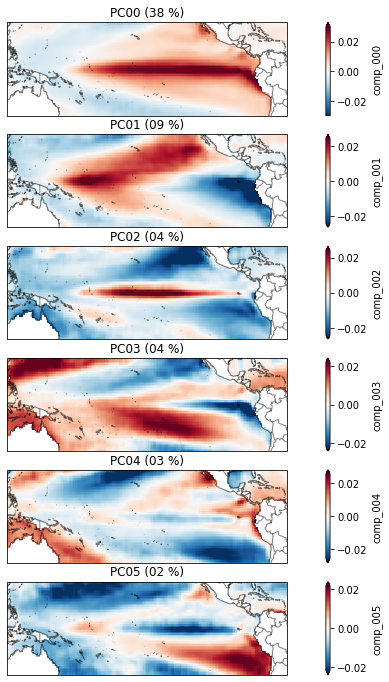

In [24]:
fig, axarr = plt.subplots(6, 1, figsize=(14,12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

for i, ax in enumerate(axarr.flatten()):
    loadings[f'comp_00{i}'].plot(ax=ax, robust=True, transform=ccrs.PlateCarree())
    ax.coastlines('50m', edgecolor='k', alpha=0.5)
    ax.add_feature(cfeature.BORDERS, edgecolor='k', alpha=0.5)

    ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
    
    ax.set_title(f'PC{i:02d} ({int(explained_variance.iloc[i]):02d} %)')

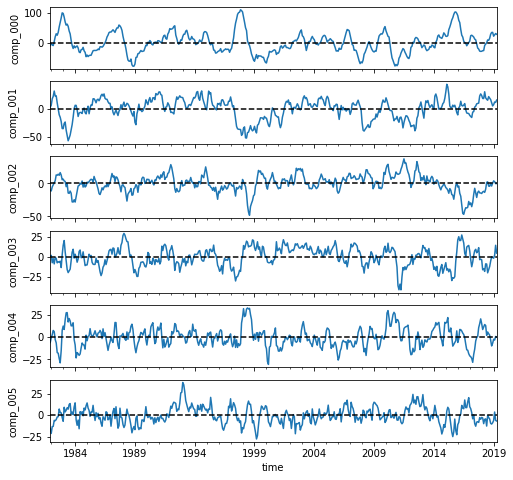

In [25]:
fig, axarr = plt.subplots(6, 1, figsize=(8,8), sharex=True)

for i, ax in enumerate(axarr.flatten()):
    pca.scores[f'comp_00{i}'].plot(ax=ax)
    ax.axhline(0, color='k', ls='--')
    ax.set_ylabel(f'comp_00{i}')

Vamos verificar se os meses em que ocorrem El Niño conforme definido na Aula 4 tem alguma semelhança com o padrão de scores que nós definimos:

Text(0, 0.5, 'PCA Score')

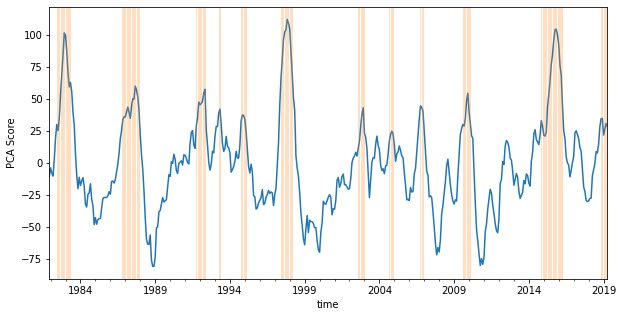

In [26]:
dates = pd.read_csv('drive/Shareddrives/Curso_Python2022/nino_dates.csv', parse_dates=True, index_col=0) # meses com el nino

fig, ax = plt.subplots(figsize=(10,5), sharex=True)
pca.scores['comp_000'].plot(ax=ax)

# plota cada um dos meses como uma linha vertical
for index, row in dates.iterrows():
  ax.axvline(index, color='C1', lw=0.5, alpha=0.5)

ax.set_ylabel('PCA Score')

**Exercício:** Leia o arquivo de precipitação `drive/Shareddrives/Python/Curso_Python/dados_NCEP_NOAA/precip.mon.mean.nc` e faça a PCA para identificar os padrões de chuva no Brasil. Para isso siga os seguintes passos: 

*   Recorte ele entre 280 e 330 de longitude e -35 a 10 de latitude
*   Faça o cálculo do acumulado anual de precipitação
*   Aplique os passos para obter os loadings e os scores conforme descrito na aula
*   Faça figuras com os loadings e scores para visualizar os padrões identificados 

In [ ]:
ds = xr.open_dataset('drive/Shareddrives/Curso_Python2022/dados_NCEP_NOAA/precip.mon.mean.nc')